Import functions from libraries

In [ ]:
from matplotlib.pyplot      import close, figure, imshow, savefig, show, title
from matplotlib.lines       import Line2D
from os.path                import join
from random                 import sample
from re                     import split
from torch                  import device, no_grad
from torch.cuda             import is_available
from torch.nn               import Linear, Module, MSELoss, ReLU, Sequential, Sigmoid
from torch.optim            import Adam
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
from torchvision.transforms import Compose, ToTensor
from torchvision.utils      import make_grid
import torch

Hyperparameters

In [ ]:
ENCODER = [28*28,400,200,100,50,25,6]  # sizes of encoder layers
DECODER = []                           # Decoder layers will be a mirror image of encoder
LR      = 0.001                        # Learning rate
N       = 32                           # Number of epochs

The Autoencoder class


In [ ]:
class AutoEncoder(Module):
    @staticmethod
    def get_non_linearity(params):
        def get_one(param):
            param = param.lower()
            if param == 'relu':
                return ReLU()
            if param == 'sigmoid':
                return Sigmoid()
            return None

        decoder_non_linearity = get_one(params[0])
        encoder_non_linearity = get_one(params[0]) if len(params) > 1 else decoder_non_linearity

        return encoder_non_linearity, decoder_non_linearity

    @staticmethod
    def build_layer(sizes, non_linearity=None):
        linears = [Linear(m, n) for m, n in zip(sizes[:-1], sizes[1:])]
        if non_linearity is None:
            return Sequential(*linears)
        else:
            return Sequential(*[item for pair in [(layer, non_linearity) for layer in linears] for item in pair])

    def __init__(self, encoder_sizes=[28*28, 400, 200, 100, 50, 25, 6],
                 encoder_non_linearity=ReLU(inplace=True),
                 decoder_sizes=[],
                 decoder_non_linearity=ReLU(inplace=True)):
        super().__init__()
        self.encoder_sizes = encoder_sizes
        self.decoder_sizes = encoder_sizes[::-1] if len(decoder_sizes) == 0 else decoder_sizes
        self.encoder = AutoEncoder.build_layer(self.encoder_sizes,
                                               non_linearity=encoder_non_linearity)
        self.decoder = AutoEncoder.build_layer(self.decoder_sizes,
                                               non_linearity=decoder_non_linearity)
        self.encode = True
        self.decode = True

    def forward(self, x):
        if self.encode:
            x = self.encoder(x)

        if self.decode:
            x = self.decoder(x)
        return x

    def n_encoded(self):
        return self.encoder_sizes[-1]


Function to train network

In [ ]:
def train(loader, model, optimizer, criterion, N=25, dev='cpu'):
    Losses = []
    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            batch_features = batch_features.view(-1, 784).to(dev)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')
    return Losses

Initialize network and data, and prepare to train


In [ ]:
def reconstruct(loader, model, criterion, N=25, prefix='test', show=False, figs='./figs', n_images=-1):
    def plot(original=None, decoded=None):
        fig = figure(figsize=(10, 10))
        ax = fig.subplots(nrows=2)
        ax[0].imshow(make_grid(original.view(-1, 1, 28, 28)).permute(1, 2, 0))
        ax[0].set_title('Raw images')
        scaled_decoded = decoded / decoded.max()
        ax[1].imshow(make_grid(scaled_decoded.view(-1, 1, 28, 28)).permute(1, 2, 0))
        ax[1].set_title(f'Reconstructed images after {N} epochs')
        savefig(join(figs, f'{prefix}-comparison-{i}'))
        if not show:
            close(fig)

    samples = [] if n_images == -1 else sample(range(len(loader) // loader.batch_size),
                                               k=n_images)
    loss = 0.0
    with no_grad():
        for i, (batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, 784).to(dev)
            outputs = model(batch_features)
            test_loss = criterion(outputs, batch_features)
            loss += test_loss.item()
            if len(samples) == 0 or i in samples:
                plot(original=batch_features,
                     decoded=outputs)
    return loss

In [ ]:
# Add noise lambda function
noise_lambda = lambda x: x + 0.5 * torch.rand_like(x)  # Adjust noise factor as needed

# Modify the dataset loading process to add noise using a lambda function
class NoisyMNIST(MNIST):
    def __init__(self, *args, noise_lambda=lambda x: x, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_lambda = noise_lambda

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img = self.noise_lambda(img)  # Add noise using the lambda function
        return img, _


dev = device("cuda" if is_available() else "cpu")
encoder_non_linearity, decoder_non_linearity = AutoEncoder.get_non_linearity(['relu'])
model = AutoEncoder(encoder_sizes=ENCODER,
                    encoder_non_linearity=encoder_non_linearity,
                    decoder_non_linearity=decoder_non_linearity,
                    decoder_sizes=DECODER).to(dev)
optimizer = Adam(model.parameters(),
                 lr=LR)
criterion = MSELoss()
transform = Compose([ToTensor()])

train_dataset = NoisyMNIST(root="~/torch_datasets",
                           train=True,
                           transform=transform,
                           download=True,
                           noise_lambda=noise_lambda)
test_dataset = NoisyMNIST(root="~/torch_datasets",
                          train=False,
                          transform=transform,
                          download=True,
                          noise_lambda=noise_lambda)

train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 185826522.76it/s]

Extracting /root/torch_datasets/NoisyMNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/NoisyMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 71847979.73it/s]


Extracting /root/torch_datasets/NoisyMNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/NoisyMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43920460.53it/s]

Extracting /root/torch_datasets/NoisyMNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/NoisyMNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14163961.91it/s]


Extracting /root/torch_datasets/NoisyMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/NoisyMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train network

In [ ]:
Losses = train(train_loader, model, optimizer, criterion,
               N=N,
               dev=dev)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/32, loss = 0.129848
epoch : 2/32, loss = 0.096531
epoch : 3/32, loss = 0.069580
epoch : 4/32, loss = 0.062020
epoch : 5/32, loss = 0.057663
epoch : 6/32, loss = 0.054920
epoch : 7/32, loss = 0.053351
epoch : 8/32, loss = 0.052505
epoch : 9/32, loss = 0.051858
epoch : 10/32, loss = 0.051342
epoch : 11/32, loss = 0.051008
epoch : 12/32, loss = 0.050653
epoch : 13/32, loss = 0.050463
epoch : 14/32, loss = 0.050182
epoch : 15/32, loss = 0.049927
epoch : 16/32, loss = 0.049808
epoch : 17/32, loss = 0.049694
epoch : 18/32, loss = 0.049378
epoch : 19/32, loss = 0.049295
epoch : 20/32, loss = 0.049068
epoch : 21/32, loss = 0.048964
epoch : 22/32, loss = 0.048923
epoch : 23/32, loss = 0.048706
epoch : 24/32, loss = 0.048584
epoch : 25/32, loss = 0.048534
epoch : 26/32, loss = 0.048386
epoch : 27/32, loss = 0.048364
epoch : 28/32, loss = 0.048289
epoch : 29/32, loss = 0.048176
epoch : 30/32, loss = 0.048127
epoch : 31/32, loss = 0.048036
epoch : 32/32, loss = 0.047927


# Compare output layer with Inputs, to get an idea of the quality of the encoding

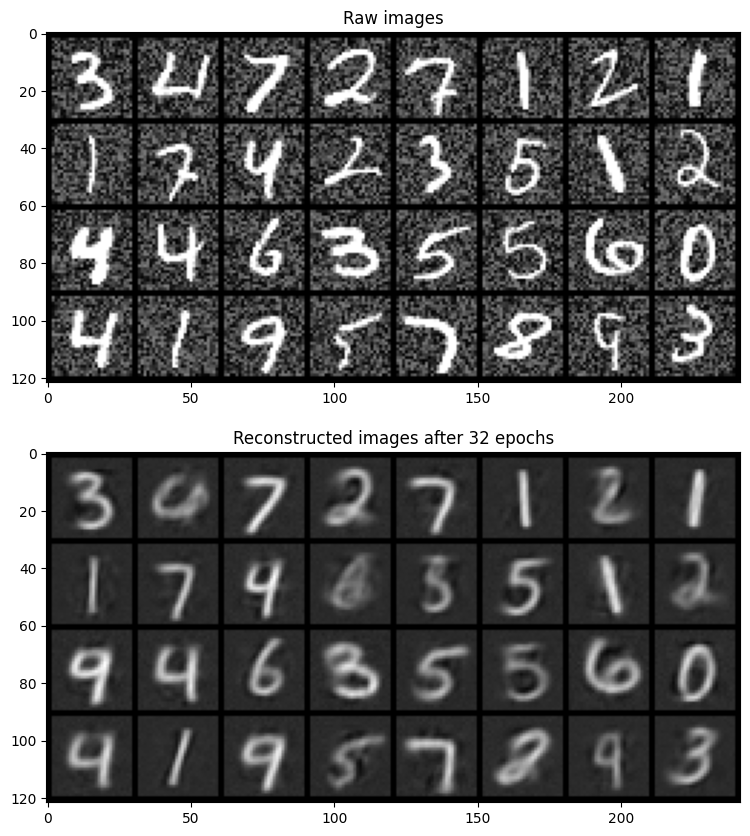

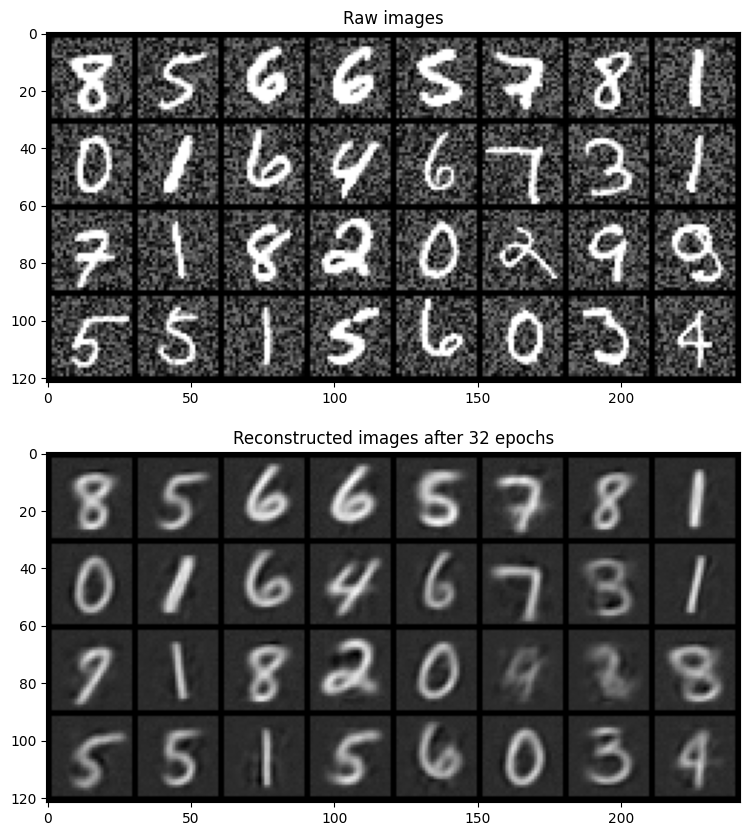

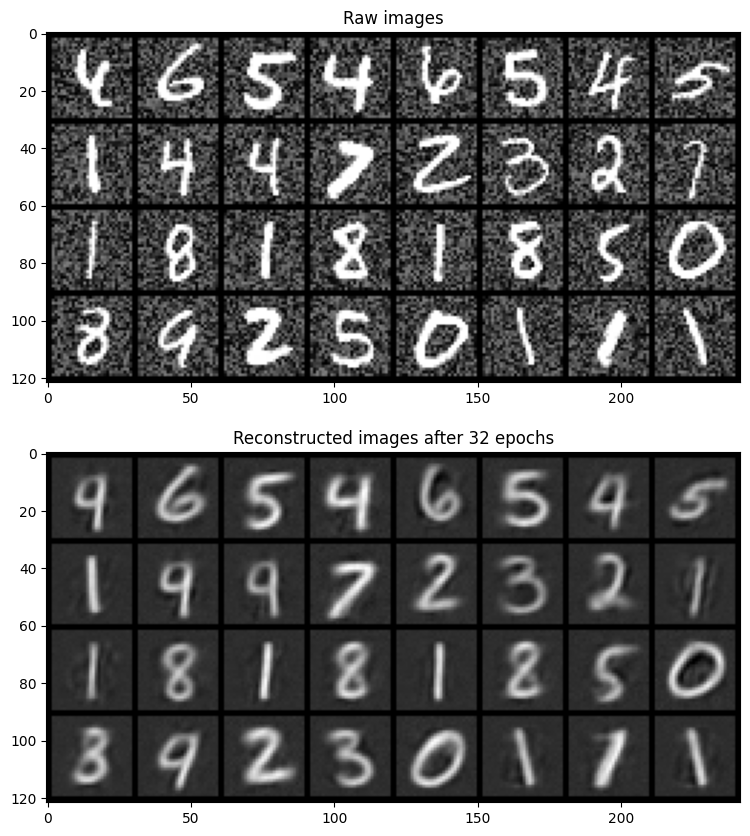

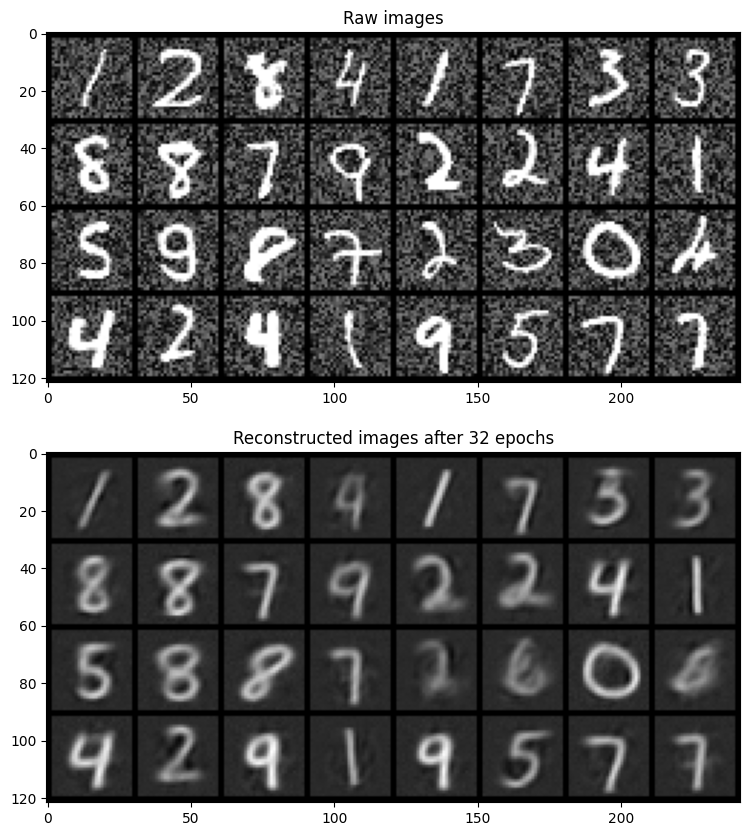

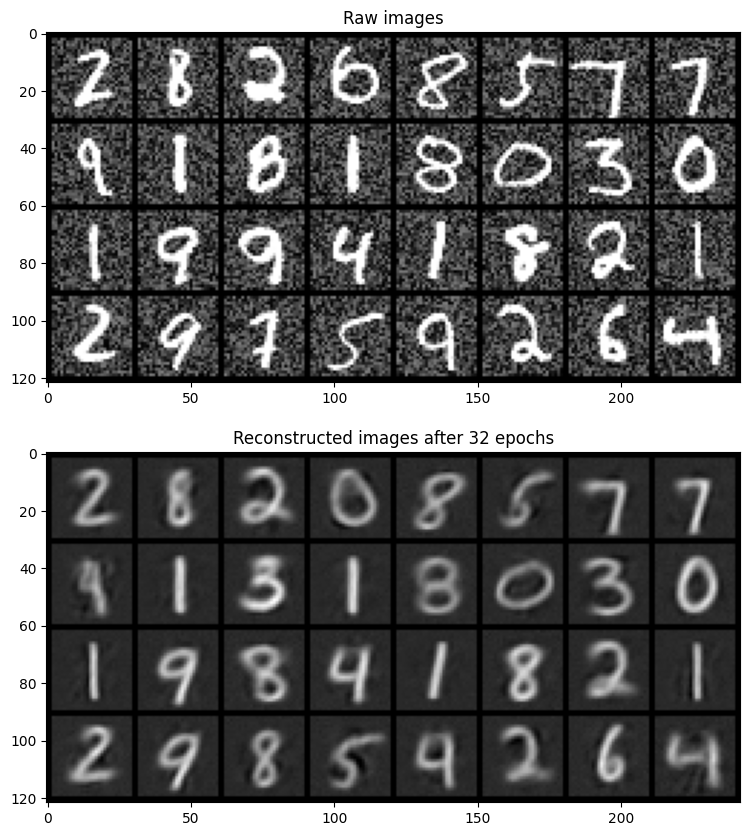

In [ ]:
test_loss = reconstruct(test_loader, model, criterion,
                        N=N,
                        show=True,
                        figs='.',
                        n_images=5,
                        prefix='foo')

In [ ]:
def plot_losses(Losses,
                lr                   = 0.001,
                encoder              = [],
                decoder              = [],
                encoder_nonlinearity = None,
                decoder_nonlinearity = None,
                N                    = 25,
                show                 = False,
                figs                 = './figs',
                prefix               = 'ae',
                test_loss            = 0):
    fig = figure(figsize=(10,10))
    ax  = fig.subplots()
    ax.plot(Losses)
    ax.set_ylim(bottom=0)
    ax.set_title(f'Training Losses after {N} epochs')
    ax.set_ylabel('MSELoss')
    ax.text(0.95, 0.95, '\n'.join([f'lr = {lr}',
                                   f'encoder = {encoder}',
                                   f'decoder = {decoder}',
                                   f'encoder nonlinearity = {encoder_nonlinearity}',
                                   f'decoder nonlinearity = {decoder_nonlinearity}',
                                   f'test loss = {test_loss:.3f}'
                                   ]),
            transform           = ax.transAxes,
            fontsize            = 14,
            verticalalignment   = 'top',
            horizontalalignment = 'right',
            bbox                = dict(boxstyle  = 'round',
                                       facecolor = 'wheat',
                                       alpha     = 0.5))
    savefig(join(figs,f'{prefix}-losses'))
    if not show:
        close (fig)

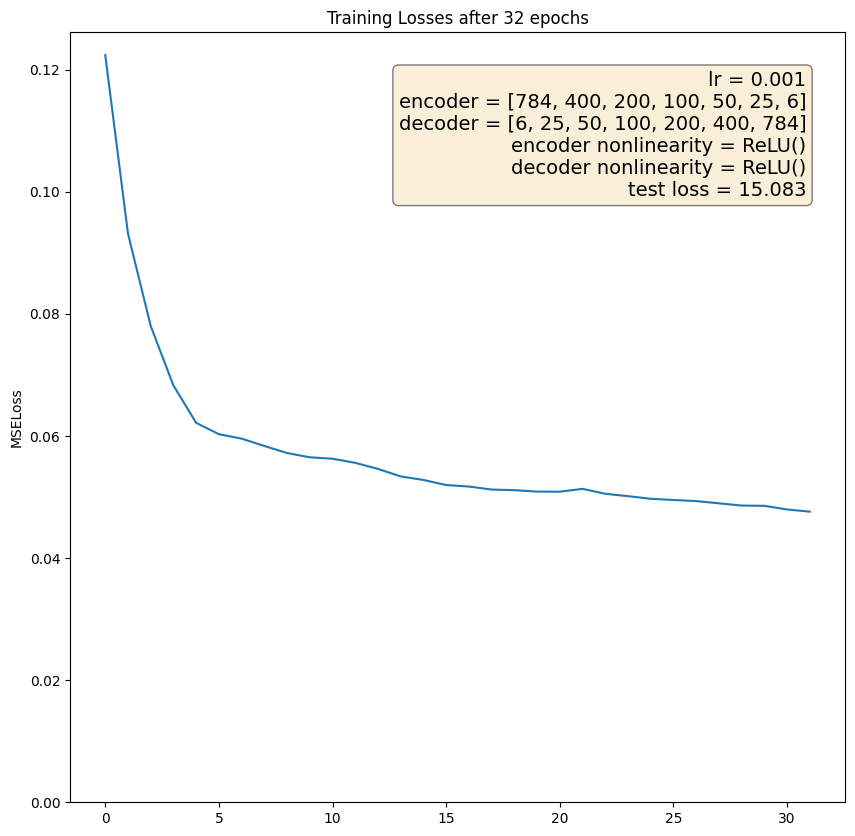

In [ ]:
    plot_losses(Losses,
                lr                   = LR,
                encoder              = model.encoder_sizes,
                decoder              = model.decoder_sizes,
                encoder_nonlinearity = encoder_non_linearity,
                decoder_nonlinearity = decoder_non_linearity,
                N                    = N,
                show                 = True,
                figs                 = '.',
                prefix               = 'foo',
                test_loss            = test_loss)